## Amazon SageMaker Random Cut Forest model training and deployment

This notebook provides a set of instructions to train and deploy Amazon SageMaker Random Cut Forest(RCF) model. Amazon Sagemaker RCF is an algorithm designed to detect anomalous data points within a dataset. 
To train the model, we used the data over the course of one week that represents a normal pattern. Then, we fed the whole data into the model for testing.

In [11]:
import boto3
import botocore
import sagemaker
import sys
import datetime
from tzlocal import get_localzone as tzlocal
import time
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import io

In [771]:
!pip install tzlocal

You are using pip version 10.0.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


These are functions that will be used below for plotting results of the model.

In [12]:
def plot_result(ax1, indata, cutoffs, is_cutoff, y_label, color):
        
    start, end = 0, len(indata)
    indata_subset = indata[start:end]

    ax1.plot(indata, color=color)
 
    if is_cutoff == True:
        ax1.plot(cutoffs, color = 'red')        

    ax1.grid(which='major', axis='both')
    ax1.set_ylabel(y_label, color='C0')   
    
    a = numpy.array(['2018-12-20']);
    c = numpy.append(a, testdata.iloc[:, 3][::10000].reshape(-1, 1))
    
    ax1.xaxis.set_ticklabels(c) 

In [13]:
def plot_results(indata, threshold, in_scores, is_stepbystep):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
   
    #
    # *Try this out* - change `start` and `end` to zoom in on the 
    # anomaly found earlier in this notebook
    #
    start, end = 0, len(indata)
    #start, end = 5500, 6500
    indata_subset = indata[start:end]

    ax1.plot(indata_subset.iloc[:, 1], color='C0', alpha=0.8)
    ax2.plot(indata_subset['score'], color='C1')
    if is_stepbystep == False:
        ax2.plot(numpy.full(len(indata_subset), threshold), color = 'C2')
    else:
        ax2.plot(indata_subset['cutoff'], color = 'C2')

    ax1.grid(which='major', axis='both')

    ax1.set_ylabel('Sum value', color='C0')
    ax2.set_ylabel('Anomaly Score', color='C1')

    ax1.tick_params('y', colors='C0')
    ax2.tick_params('y', colors='C1')

    ax1.set_ylim(0, numpy.max(indata.iloc[:, 1]))
    if is_stepbystep == False:
        ax2.set_ylim(min(in_scores), 1.4*max(in_scores))
    else:
        ax2.set_ylim(testdata['score'].min(), 1.6*testdata['score'].max())
    fig.set_figwidth(12)
    
    #a = numpy.array(['2018-12-20']);
    #c = numpy.append(a, indata.iloc[:, 3][::2000].reshape(-1, 1))
    
    #ax1.xaxis.set_ticklabels(c)  

We first need to specify the locations where we will store our training data and trained model artifacts. 
In particular, we need the following data:
    
* bucket - An S3 bucket accessible by this account.
* prefix - The location in the bucket where this notebook's input and output data will be stored. (The default value is sufficient.)


In [14]:
bucket = 'kintestingdata'
prefix = 'sagemaker/rcf-benchmarks'
execution_role = sagemaker.get_execution_role()
# check if the bucket exists
try:
    boto3.Session().client('s3').head_bucket(Bucket=bucket)
except botocore.exceptions.ParamValidationError as e:
    print('Hey! You either forgot to specify your S3 bucket'
          ' or you gave your bucket an invalid name!')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == '403':
        print("Hey! You don't have permission to access the bucket, {}.".format(bucket))
    elif e.response['Error']['Code'] == '404':
        print("Hey! Your bucket, {}, doesn't exist!".format(bucket))
    else:
        raise
else:
    print('Training input/output will be stored in: s3://{}/{}'.format(bucket, prefix))

Training input/output will be stored in: s3://kintestingdata/sagemaker/rcf-benchmarks


The training data consists of one-minute interval data over the course of one week that represents a normal pattern

In [15]:
key = 'rcf/playdata/train/medium_one_min_train.csv'
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key=key)
bmw_data = pd.read_csv(io.BytesIO(obj['Body'].read()),  delimiter=',', header=None)
bmw_data = bmw_data.dropna()
bmw_data.head()

,0,1
0,2019-01-15_00-00,31255
1,2019-01-15_00-01,30706
2,2019-01-15_00-02,29039
3,2019-01-15_00-03,31450
4,2019-01-15_00-04,28855


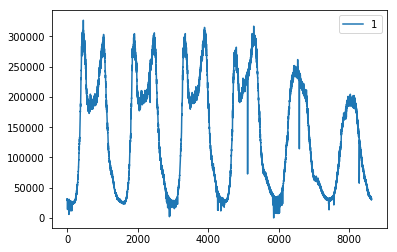

In [16]:
bmw_data.plot()

In [17]:
num_val_array = numpy.array(bmw_data.values[:, 1]).reshape(-1,1)
num_val_array = numpy.around(num_val_array.astype(numpy.float), 3)

Next, we configure a SageMaker training job to train the Random Cut Forest (RCF) algorithm. We specify 2 hyper parameters: 
* num_samples_per_tree = 512
* num_trees = 100

Their values are subject to change.

In [18]:
from sagemaker import RandomCutForest

session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=512,
                      num_trees=100)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(num_val_array))

INFO:sagemaker:Creating training-job with name: randomcutforest-2019-02-27-11-36-50-418


2019-02-27 11:36:50 Starting - Starting the training job...
2019-02-27 11:36:51 Starting - Launching requested ML instances......
2019-02-27 11:37:56 Starting - Preparing the instances for training......
2019-02-27 11:39:18 Downloading - Downloading input data
2019-02-27 11:39:18 Training - Downloading the training image...
2019-02-27 11:39:49 Uploading - Uploading generated training model
Docker entrypoint called with argument(s): train
[02/27/2019 11:39:46 INFO 140166256744256] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ftp_port': 8999, u'num_samples_per_tree': 256, u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recall_fscore'], u'_num_kv_servers': u'auto', u'mini_batch_size': 1000}
[02/27/2019 11:39:46 INFO 140166256744256] Reading provided configur


2019-02-27 11:39:55 Completed - Training job completed
Billable seconds: 56


In [19]:
print('Training job name: {}'.format(rcf.latest_training_job.job_name))

Training job name: randomcutforest-2019-02-27-11-36-50-418


The trained model should be deployed. We create an inference endpoint using the SageMaker Python SDK deploy() function from the job we defined above

In [20]:
rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)

from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer

print('Endpoint name: {}'.format(rcf_inference.endpoint))

INFO:sagemaker:Creating model with name: randomcutforest-2019-02-27-11-40-51-543
INFO:sagemaker:Creating endpoint with name randomcutforest-2019-02-27-11-36-50-418


----------------------------------------------------------------------------!Endpoint name: randomcutforest-2019-02-27-11-36-50-418


The model outputs an anomaly score for each input datapoint. 

In [21]:
results = rcf_inference.predict(num_val_array)
scores = [datum['score'] for datum in results['scores']]

bmw_data['score'] = pd.Series(scores, index=bmw_data.index)
bmw_data.head()

start, end = 0, len(bmw_data)
bmw_data_subset = bmw_data[start:end]

It is suggested in RCF documentation, to compute a value of the anomaly threshold as 3 standard deviations from the mean score. Any value that is beyond the threshold is considered as an anomaly. 


In [23]:
score_mean = bmw_data['score'].mean()
score_std = bmw_data['score'].std()
score_cutoff = score_mean + 3*score_std

print(score_cutoff)
anomalies = bmw_data_subset[bmw_data_subset['score'] > score_cutoff]
#anomalies

4.988821833707875


Here we plot results on the training data. The blue plot corresponds to the training data, the orange one - to anomaly scores, and a green line depicts the value of the threshold.

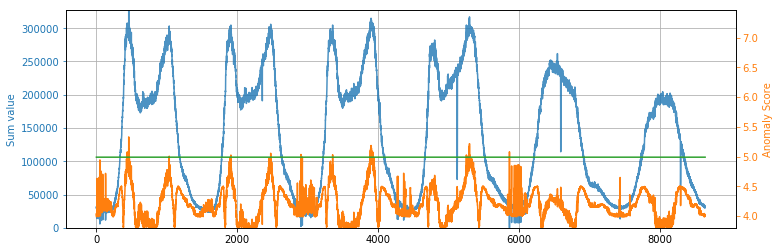

In [24]:
plot_results(bmw_data, score_cutoff, scores, False)

Next, we apply the trained model for testing purposes.

In [25]:
key_test = 'rcf/playdata/test/medium_one_min.csv'

obj = s3.get_object(Bucket=bucket, Key=key_test)
testdata = pd.read_csv(io.BytesIO(obj['Body'].read()),  delimiter=',', header=None)
testdata = testdata.dropna()
testdata.head()

,0,1
0,2018-12-21_15-16,138
1,2018-12-21_15-19,72
2,2018-12-21_15-22,62
3,2018-12-21_15-23,56
4,2018-12-21_15-24,257


In [26]:
test_num_val_array = numpy.array(testdata.values[:, 1]).reshape(-1,1)
test_num_val_array = numpy.around(test_num_val_array.astype(numpy.float), 3)

results = rcf_inference.predict(test_num_val_array)
scores = [datum['score'] for datum in results['scores']]

timestamp_array = numpy.array(testdata.values[:, 0]).reshape(-1,1)

testdata['score'] = pd.Series(scores, index=testdata.index)
testdata.head()

start, end = 0, len(testdata)
testdata_subset = testdata[start:end]

In [27]:
scores_array = numpy.array(scores)
score_mean = scores_array.mean()
score_std = scores_array.std()
score_cutoff = score_mean + 3*score_std

#print(score_cutoff)

anomalies = scores_array[scores_array > score_cutoff]

testdata['score'] = pd.Series(scores, index=testdata.index)

#testdata.loc[testdata["score"] > score_cutoff]

Here are the testing results. The threshold is computed on the whole testing data.  As we can see, not only high local peaks are detected as anomalies, but also local downfalls and congestions on the bottom are anomaly candidates. 


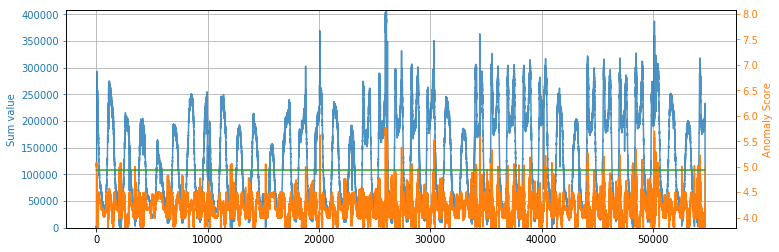

In [28]:
plot_results(testdata, score_cutoff, scores, False)

We can experiment and compute the threshold after each day. In this case, we have one threshold per each day.

In [29]:
#Day by day testing
#strdates = testdata[0].str.split(" ", n = 1, expand = True)[0]
strdates = testdata[0].str[0:10]
testdata['strdate'] = pd.Series(strdates, index=testdata.index)
testdata['cutoff'] = pd.Series(numpy.zeros(len(strdates)), index=testdata.index)

In [31]:
unique_dates = testdata.groupby("strdate").nunique().index
newdataframe = pd.DataFrame
a = 0

for i in unique_dates:
    day_subset = testdata[testdata['strdate'] == i]
    
    num_array = numpy.array(day_subset.values[:, 1]).reshape(-1,1)
    results = rcf_inference.predict(num_array)
    scores = [datum['score'] for datum in results['scores']]

    testdata.loc[testdata["strdate"] == i, 'score'] = scores
       
    scores_array = numpy.array(scores)
    score_mean = scores_array.mean()
    score_std = scores_array.std()
    score_cutoff = score_mean + 3*score_std
    testdata.loc[testdata["strdate"] == i, 'cutoff'] = score_cutoff
    
    anomalies = scores_array[scores_array > score_cutoff]
    #if (len(anomalies) > 0):
    #    anom_indices = numpy.argwhere(scores_array > score_cutoff)
    #    print(testdata.loc[(testdata["strdate"] == i) & (testdata["score"] > score_cutoff)])
     
print('Finished!')   

Finished!


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:15: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


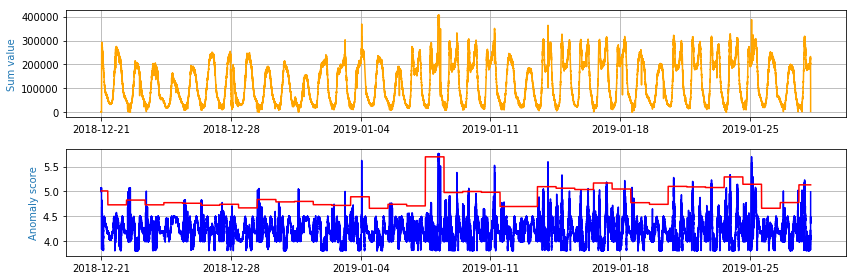

In [32]:
fig, (px1, px2) = plt.subplots(nrows=2, ncols=1)

fig.set_figwidth(12)
plot_result(px1, testdata.iloc[:, 1], '',  False, 'Sum value', 'orange')
plot_result(px2, testdata['score'], testdata['cutoff'],  True, 'Anomaly score', 'blue')
plt.tight_layout()